In [1]:
import nidaqmx
from nidaqmx.constants import LineGrouping,Edge, AcquisitionType, VoltageUnits, TerminalConfiguration, READ_ALL_AVAILABLE
# from nidaqmx import stream_readers
from nidaqmx.stream_writers import DigitalSingleChannelWriter, DigitalMultiChannelWriter
from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np
import matplotlib.pyplot as plt

In [111]:
from hardware.pulser.pulser import PulseGenerator, HIGH, LOW, INF
PS_ip = "169.254.8.2"
PSch_Laser = 0 # trigger the laser
PSch_DAQClock = 1 # as the clock for DAQ
PSch_DAQstart = 3 # trigger pulse to start the DAQ
chmap = {"laser":PSch_Laser, "clock":PSch_DAQClock, "daqtrig":PSch_DAQstart}
pg  = PulseGenerator(ip=PS_ip, chmap=chmap)

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.6.2
Client software: v1.6.0


In [143]:
from hardware.positioner.positioner import XYZPositioner
xyzpp = XYZPositioner(ip="192.168.1.78", xaxis=0, yaxis=1, zaxis=2)
xyzpp.open_control()
mode = "trigger"

rate_slipstick = 4000E3 # [mHz],  from 1Hz to 5kHz

out_amp = 30E3 # [mV],  from 0 to 60V
out_offset = 0.0 # [mV] from 0 to 60V
target_range = 5.0*1000 # nm

xyzpp.control.setControlAmplitude(xyzpp.xaxis, out_amp)
xyzpp.control.setControlFixOutputVoltage(xyzpp.xaxis, out_offset)
xyzpp.control.setControlFrequency(xyzpp.xaxis, rate_slipstick)
xyzpp.control.setControlFixOutputVoltage(xyzpp.xaxis, out_offset)
xyzpp.control.setControlTargetRange(xyzpp.xaxis, target_range)


xyzpp.control.setControlAmplitude(xyzpp.yaxis, out_amp)
xyzpp.control.setControlFixOutputVoltage(xyzpp.yaxis, out_offset)
xyzpp.control.setControlFrequency(xyzpp.yaxis, rate_slipstick)
xyzpp.control.setControlFixOutputVoltage(xyzpp.yaxis, out_offset)
xyzpp.control.setControlTargetRange(xyzpp.yaxis, target_range)


stepsperpulse = 10 # for open loop only

xyzpp.rtin.setRealTimeInMode(xyzpp.xaxis, 10) # Trigger LVTTL
xyzpp.rtin.setRealTimeInMode(xyzpp.yaxis, 10) # Trigger LVTTL
xyzpp.rtin.setRealTimeInFeedbackLoopMode(xyzpp.xaxis, 0) # 0:open loop, 1:close loop
xyzpp.rtin.setRealTimeInFeedbackLoopMode(xyzpp.yaxis, 0)
xyzpp.rtin.setRealTimeInStepsPerPulse(xyzpp.xaxis, stepsperpulse)
xyzpp.rtin.setRealTimeInStepsPerPulse(xyzpp.yaxis, stepsperpulse)
xyzpp.rtin.apply()
xyzpp.rtout.setMode(xyzpp.xaxis, 0) # turn off output mode
xyzpp.rtout.setMode(xyzpp.yaxis, 0) # turn off output mode
xyzpp.rtout.setMode(xyzpp.zaxis, 0) # turn off output mode
xyzpp.rtout.apply()

# xyzpp.close()

## Raster Scan
### fast open-loop line scan + slow close-loop line scan
positioner comes back to starting pointing point after each line,
use close loop for slow axis, open loop for fast axis

In [144]:
# hardware conneciton setting 
fastaxis = "y"
if fastaxis == "x":
    ch_forw = 8 # P0 digital channel for forward motion of fast axis
    ch_back = 9
elif fastaxis == "y":
    ch_forw = 10 
    ch_back = 11
NI_ch_APD = "/Dev1/ai16"
NI_ch_Clock = "/Dev1/PFI8" # clock source
NI_ch_Trig = "/Dev1/PFI9" # clock gate
NI_ch_XYZstageTrig = "/Dev1/port0/line8:13"

# signal reading parameters
min_volt = -1E-3 # [V]
max_volt = 10
samplerate_read = 0.1E6 # 500kHz .max ext clock rate of NI6343
basetime = 1.0/samplerate_read
timeout_read = 10

# scan parameters
dutyportion = 0.3
num_fastaxis = 100
num_slowaxis = 100
pos_fixaxis = 900E3
pos_begin_fa = 500E3
poslist_end_fa = np.zeros(num_slowaxis) # the end position of the fast is unknown in advance because it travels in open loop, it will be measured for each scan line
pos_begin_sa = 2100E3 # use absolute position in nm
pos_end_sa = 2600E3 # use absolute position in nm
travellist_sa = np.linspace(pos_begin_sa, pos_end_sa, num_slowaxis, endpoint=True)

samplerate_scantrig = (dutyportion * (rate_slipstick/1000.0)/stepsperpulse*2)
assert samplerate_read >= samplerate_scantrig 
samplerate_scantrig = 1.0/((round((1.0/samplerate_scantrig)/basetime)//2)*2*basetime)
# datanum_per_scanpoint = 2*samplerate_read/samplerate_scan
datanum_per_scanpoint = int(round(2*samplerate_read/samplerate_scantrig))
samplerate_scantrig = samplerate_read/datanum_per_scanpoint*2
assert datanum_per_scanpoint%2 == 0
num_readsample = num_fastaxis*datanum_per_scanpoint 

ttl_forw_line_fa = ([0]*(datanum_per_scanpoint//2) + [2**ch_forw]*(datanum_per_scanpoint//2))*num_fastaxis # use rasing edge to trigger
linescantime = num_readsample/samplerate_read
ttl_scan_fa = np.array(ttl_forw_line_fa, dtype=np.uint32)
dotowrite = ttl_scan_fa 

print(f"Read sample rate for NIDAQ:{samplerate_read}")
print(f"Scan sample rate:{samplerate_scantrig}")
print(f"Number of data per Scan point: {datanum_per_scanpoint}")
print(f"Estimated Line Scan Time:{linescantime} s")
print(f"Trigger pulses for fast axis {str(ttl_scan_fa)}")
print(f"Number of Sample to read: {num_readsample}")



Read sample rate for NIDAQ:100000.0
Scan sample rate:240.3846153846154
Number of data per Scan point: 832
Estimated Line Scan Time:0.832 s
Trigger pulses for fast axis [   0    0    0 ... 1024 1024 1024]
Number of Sample to read: 83200


In [145]:
# setting for Pulse Streamer
off_begin = 300 # 3000ns
on_time = linescantime*1E9 # in ns 
off_end = 300 # 3000ns
movetime = (stepsperpulse/rate_slipstick)*1E9
statictime = (datanum_per_scanpoint/samplerate_read)*1E9-movetime
clockperiod = basetime*1E9
seq_clock = [(off_begin, LOW)]+[(clockperiod/2, HIGH), (clockperiod/2, LOW) ]+[(clockperiod/2, HIGH), (clockperiod/2, LOW) ]*num_readsample+[(off_end, LOW)]
seq_laser = [(off_begin, LOW)]+[(clockperiod/2, HIGH), (clockperiod/2, LOW) ]+[(movetime, LOW), (statictime, HIGH)]*num_fastaxis+[(off_end, LOW)]
seq_daqtrig = [(off_begin, LOW)]+[(clockperiod/2, HIGH), (clockperiod/2, LOW) ]+[(on_time, HIGH)]+[(off_end, LOW)]

pg.setDigital("clock", seq_clock)
pg.setDigital("daqtrig", seq_daqtrig)
pg.setDigital("laser", seq_laser)
pg.setTrigger()

[[1.28445443 1.29965126 1.30256464 ... 1.36949691 1.36866762 1.36701061]
 [1.28060795 1.29040393 1.29339191 ... 1.35473701 1.35247412 1.35259372]
 [1.2841055  1.29491155 1.29704261 ... 1.36190026 1.36371634 1.36050574]
 ...
 [1.24691328 1.25991946 1.2571541  ... 1.32315958 1.32052526 1.31949269]
 [1.23507821 1.24893066 1.25030347 ... 1.3128331  1.31460023 1.3126985 ]
 [1.22935882 1.2439257  1.24479485 ... 1.30803733 1.30576695 1.30670597]]


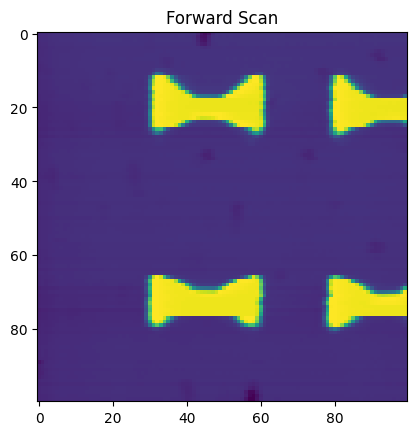

In [147]:
buffer_readpoint = np.zeros(datanum_per_scanpoint, dtype=np.float64, order='C')
scandata = np.zeros((num_slowaxis, num_fastaxis), dtype=np.float64, order='C')

scantask = nidaqmx.Task("scanner")
readtask = nidaqmx.Task("readsignal")


try:
    scantask.do_channels.add_do_chan(NI_ch_XYZstageTrig)
    scantask.timing.cfg_samp_clk_timing(samplerate_read, source="", active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
    scan_trig = scantask.triggers.start_trigger
    scan_trig.cfg_dig_edge_start_trig(NI_ch_Trig, Edge.RISING)

    readtask.ai_channels.add_ai_voltage_chan(
                NI_ch_APD,"",
                # TerminalConfiguration.RSE,
                TerminalConfiguration.DIFF,
                min_volt,max_volt,
                VoltageUnits.VOLTS
            )
    readtask.timing.cfg_samp_clk_timing(samplerate_read, source="", active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
    read_trig = readtask.triggers.start_trigger
    read_trig.cfg_dig_edge_start_trig(NI_ch_Trig, Edge.RISING)

    timerout_readpoint = max(datanum_per_scanpoint/samplerate_read, 10)
    # print()
    # print(f"timerout_readpoint: {timerout_readpoint}s")
    # for ii in range(num_slowaxis):
    
    for ii in range(num_slowaxis):
        # xyzpp.set_pos([pos_begin_fa, travellist_sa[ii], pos_fixaxis])
        xyzpp.set_pos([travellist_sa[ii], pos_begin_fa, pos_fixaxis])
        writestream = DigitalSingleChannelWriter(scantask.out_stream, auto_start=False)
        written = writestream.write_many_sample_port_uint32(dotowrite, timeout=10)

        reader = AnalogSingleChannelReader(readtask.in_stream)
                # reader = stream_readers.AnalogMultiChannelReader(task.in_stream)
        reader.read_all_avail_samp  = True

        scantask.start() #start line scanning
        readtask.start() #start reading data
        pg.stream(n_runs=1)
        # forward scan points
        for jj in range(num_fastaxis):
            num_read = reader.read_many_sample(
                    buffer_readpoint,
                    datanum_per_scanpoint,
                    timerout_readpoint
                )
            if num_read == datanum_per_scanpoint:
                idx = (ii*num_fastaxis+jj)*datanum_per_scanpoint
                scandata[ii, jj] = np.mean(buffer_readpoint)
                # print("read data for a scan")
            else:
                print(f"forward scan point fucked...at i={ii}, j={jj}")
        scantask.wait_until_done(timeout=max(linescantime, 10)) # block the code below, optional
        readtask.wait_until_done(timeout=max(linescantime, 10)) # block the code below, optional
        scantask.stop()
        readtask.stop()
except Exception as ee:
    print(ee)
finally:
    pg.constant()
    scantask.close()
    readtask.close()

# show the scans 
print(scandata)
plt.figure()
plt.imshow(scandata)
plt.title("Forward Scan")
plt.show()

[[0.0350851  0.03564062 0.03605659 ... 0.03595322 0.03575987 0.03569324]
 [0.03502318 0.03562949 0.03606092 ... 0.03453115 0.03434163 0.03426906]
 [0.03502835 0.03562129 0.03607773 ... 0.0351465  0.0352265  0.03523628]
 ...
 [0.0354618  0.03610574 0.03656651 ... 0.03548754 0.03539826 0.03530386]
 [0.03562279 0.03614806 0.03653455 ... 0.03530485 0.03535803 0.03547297]
 [0.03555461 0.03612008 0.03653162 ... 0.03558433 0.03550897 0.03549748]]


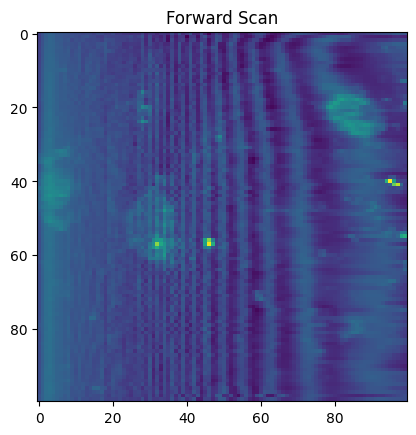

In [84]:
# show the scans 
print(scandata)
plt.figure()
plt.imshow(scandata)
plt.title("Forward Scan")
plt.show()